In [21]:
#importing libraries
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
import pandas as pd


In [22]:
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


This, week:

* Randomise x_test and x_train
* Measure the MSE, KL, and Cost for the _testing_ data
* Create a multi-variable function for the model to predict

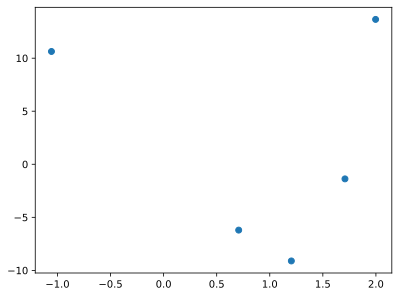

In [23]:
x_train = torch.rand(5)*4-2
y_train = x_train.pow(5) - 10 * x_train.pow(1) + 2*torch.rand(x_train.size())

plt.scatter(x_train.data.numpy(), y_train.data.numpy())
plt.show()

x_train = torch.unsqueeze(x_train, dim=1).to(device)
y_train = torch.unsqueeze(y_train, dim=1).to(device)



In [24]:
def clean_target(x):
    return x.pow(5) - 10 * x.pow(1)+1


def target(x):
    return x.pow(5) - 10 * x.pow(1) + 2*torch.rand(x.size())


In [25]:
no_of_neurones = 2000

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=no_of_neurones),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=1),
).to(device)

In [26]:
mse_loss = nn.MSELoss().to(device)
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)


Now, I need to create a function that trains the model. When retraining the model, I'll need to be able to call this function multiple times.

In [27]:
def train(model: nn.Sequential, x_train: torch.Tensor, y_train: torch.Tensor, epochs: int):
    for _ in range(epochs):
        predictions = model(x_train)
        mse = mse_loss(predictions, y_train)
        kl = kl_loss(model)
        cost = mse + kl_weight * kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    print(f'- With {epochs} epochs, MSE : {mse.item():2.2f}, KL : {kl.item():2.2f}, Cost: {cost.item():2.2f}')

    return model, mse, kl, cost

In [28]:
#creating testing data
x_test = torch.sort(torch.rand(300)*4-2)[0]
y_test = target(x_test)

x_test = torch.unsqueeze(x_test, dim=1).to(device) 
y_test = torch.unsqueeze(y_test, dim=1).to(device)

epochs = 500
model, mse, kl, cost = train(model, x_test, y_test, epochs)

model_results = np.array([model(x_test).cpu().data.numpy() for _ in range(10000)])[:,:,0].T
mean_model_results = np.array([np.mean(model_results[i]) for i in range(model_results.shape[0])])
std_model_results = np.array([np.std(model_results[i]) for i in range(model_results.shape[0])])


- With 500 epochs, MSE : 1.46, KL : 9.94, Cost: 1.56


While the cost function is above 1, I need to use the following algorithm:

* Form a numpy array of the range between mean_model_results and y_test
* Form a df of x_test and range
* Initialise an array of x values to add to the model for retraining, x_to_add
* In increments of 10, add half of x vals corresponding to highest range to x_to_add
* Randomly select 10 values from x_to_add to concatenate with x_train
* Retrain the model
* Apply x_test on model, and find its mse, kl, and cost

In [29]:
while cost.item() > 1.0:
    x_test = x_test.cpu()
    y_test = y_test.cpu()

    differences = np.abs(mean_model_results - y_test.data.numpy()[:,0])
    df = pd.DataFrame(
        {
            "x":x_test[:,0],
            "differences":differences
        }
    ).sort_values(by=['differences'], ascending=False)
    df.head()

    x_to_add = np.array([])

    #select 10 random values from x_to_add to add to x_train
    for i in range(0, len(df)+1, 10):
        x_to_add = np.append(x_to_add, df.iloc[i:i+5,0])

    x_to_add = torch.unsqueeze(torch.Tensor(np.random.choice(x_to_add, 5, replace=False)), dim=1).to(device)
    y_to_add = target(x_to_add.cpu()).to(device)

    x_train = torch.sort(torch.cat((x_train, x_to_add)).to(device))[0]    
    y_train = torch.cat((y_train, y_to_add))
    print(len(x_train))

    model, mse, kl, cost = train(model, x_train, y_train, epochs)


    x_test = torch.sort(torch.rand(300)*4-2)[0]
    y_test = target(x_test)

    x_test = torch.unsqueeze(x_test, dim=1).to(device)
    y_test = torch.unsqueeze(y_test, dim=1).to(device)


    model, mse, kl, cost = train(model, x_test, y_test, epochs)

    if(cost.item() <= 1.5):
        break

print("Cost sufficiently minimised")

model_results = np.array([model(x_test).cpu().data.numpy() for _ in range(10000)])[:,:,0].T
mean_model_results = np.array([np.mean(model_results[i]) for i in range(model_results.shape[0])])
std_model_results = np.array([np.std(model_results[i]) for i in range(model_results.shape[0])])


10
- With 500 epochs, MSE : 2.48, KL : 9.80, Cost: 2.58
- With 500 epochs, MSE : 2.28, KL : 9.35, Cost: 2.37
15
- With 500 epochs, MSE : 0.42, KL : 9.44, Cost: 0.51
- With 500 epochs, MSE : 0.50, KL : 9.31, Cost: 0.59
Cost sufficiently minimised


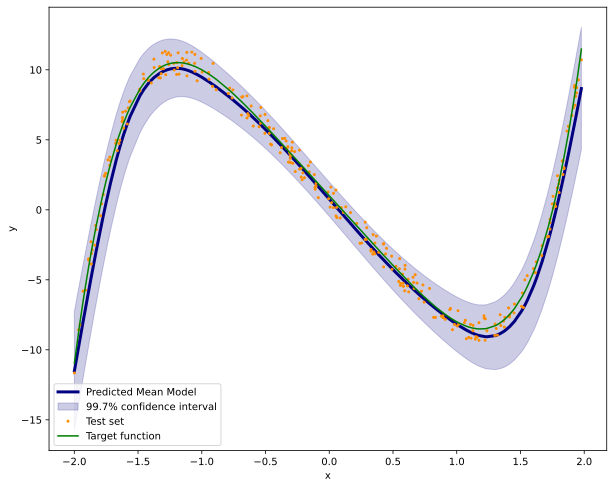

In [30]:
x_test = x_test.cpu()
y_test = y_test.cpu()

plt.figure(figsize=(10, 8))
plt.plot(x_test.data.cpu().numpy(), mean_model_results, color='navy',
        lw=3, label='Predicted Mean Model')
plt.fill_between(x_test.data.cpu().numpy().T[0], mean_model_results-3.0*std_model_results, mean_model_results +
                3.0*std_model_results, alpha=0.2, color='navy', label='99.7% confidence interval')
plt.plot(x_test.data.numpy(), y_test.data.numpy(), '.',
         color='darkorange', markersize=4, label='Test set')
plt.plot(x_test.data.cpu().numpy(), clean_target(x_test).cpu().data.numpy(),
        color='green', markersize=4, label='Target function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

plt.savefig("../../data/random_test_train.pdf")